# Семинар 8: эмбеддинги слов

## Вступление
Сегодня мы начинаем работать с текстами. Первый шаг любого пайплайна для обработки текстов на естественных языках (NLP, natural language processing) — это векторизация текстов или их составляющих (буквосочетаний, слов, словосочетаний). Иными словами, перевод текстов из формы последовательности букв/слов/токенов в числовые векторы. Такие векторы обычно называют **эмбеддингами**. Для задач NLP (part of speech tagging, named entity recognition, генерация текста, etc.) бывает полезно пользоваться готовыми эмбеддингами, полученными за нас. Далее, при решении конкретной задачи, слова в текстах заменяют готовыми эмбеддингами и поверх этого дела уже строят разные модели.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/one_hot_encoding.png?raw=1' width=40%>

Конечно же, как мы это делали в предыдущем курсе, можно использовать one-hot кодирование для каждого слова. Далее one-hot векторы можно обрабатывать обычным линейным слоем, обучать его как часть модели и получать, в целом, похожую систему. Такой подход выливается в целый ряд проблем:
- Во-первых, умножение строки в виде one-hot вектора на матрицу линейного слоя можно заменить на простую индексацию строки матрицы этого слоя.
- Во-вторых, мы можем быть заинтересованы в хорошо обученных эмбеддингах на большом датасете (чтобы векторные представления хорошо отражали смысл слов), а в нашей конкретной задаче структура и/или количество данных могут отличаться.
- В-третьих, если у нас есть основания полагать, что готовые эмбеддинги хорошо подходят для решаемой задачи, то мы можем немного сэкономить на обучении очень большого линейного слоя, ведь матрица эмбеддинигов имеет размеры `vocab_size x embed_size` и для стандартного словаря (десятки тысяч слов) может занимать больше 10 мегабайт памяти.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/lookup_matrix.png?raw=1' width=60%>

Подведём небольшие итоги. Наша цель — получить векторные представления одинакового размера для каждого слова из словаря. При этом перед обработкой слов из текста моделью, мы хотим по номеру слова в словаре брать из таблицы эмбеддингов нужный вектор и далее работать с ним как с признаковым описанием слова.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/tokenize_lookup.png?raw=1' width=40%>

Конечно эмбеддинги используются не только для слов. Эмбеддингом называют любую векторную репрезентацию дискретных объектов: слов (или частей слов), пользователей сервиса и чего только не. Для того чтобы хорошенько со всем этим разобраться, мы реализуем один из самых известных подходов к построению эмбеддингов слов — Word2Vec.

### Полезные ссылки
* [Общий взгляд](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) на Word2Vec
* [Первые работы](https://arxiv.org/pdf/1301.3781.pdf) с Word2Vec
* [Neural IPS, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) с улучшениями Word2Vec

### План семинара
1. Повторяем теорию про Word2Vec
2. Скачиваем и преодобрабатываем данные
3. Обучаем модель Skip-Gram
4. Анализируем обученную модель

Приступим!

---
## 1. Повторяем теорию про Word2Vec
<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/context_drink.png?raw=1" width=40%>

Word2Vec позволит нам не просто получить какие-то векторы чисел, соответствующие словам, а ещё и сохранить семантику слов в этих векторах. Занимательное свойство про семантику слов проявляется в том, что в полученном пространстве эмбеддингов векторы, соответствующие словам с близкими смыслами, будут иметь маленькое расстояние друг между другом. Такие слова, как «кофе», «чай» и «вода», появляются в похожих **контекстах**, а значит будут иметь близкие векторы. Различные слова будут дальше друг от друга, а отношения могут быть представлены расстоянием в векторном пространстве. Построение подхода, удовлетворяющего такому свойству, отчасти отражает наше понимание слов, ведь при прочтении неизвестного слова в *достаточном* количестве контекстов, мы учимся понимать его смысл.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/vector_distance.png?raw=1" width=40%>

Для реализации Word2Vec существует два подхода:
* **CBOW** (Continuous Bag-Of-Words). По контексту (словам вокруг) слова пытаемся предсказать центральное слово.
* **Skip-gram**. По центральному слову контекста пытаемся предсказать слова из контекста.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/word2vec_architectures.png?raw=1" width=60%>

На этом семинаре мы будем использовать **архитектуру skip-gram**, потому что она работает лучше чем CBOW.

## 2. Скачиваем и преодобрабатываем данные

1. Скачаем [dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); файл очищенного текста статьи в Википедии от Мэтта Махони
2. Очистим данные от шума
3. Сделаем маппинг слов в индексы
4. Проведём субдискретизацию текста
5. Сформируем батчи

### Качаем данные

In [1]:
import random
import warnings
from collections import Counter
from typing import List, Tuple

import numpy as np
import torch
from torch import nn, optim
from tqdm.auto import tqdm, trange

warnings.filterwarnings("ignore")

In [2]:
# !wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
# !unzip text8.zip
# !rm text8.zip

In [3]:
with open("text8") as f:
    text = f.read()

print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


### Чистим данные

Теперь почистим текст, чтобы облегчить обучение. Вся логика реализована за нас в функции `preprocess` из файла `utils.py`. Функция делает несколько вещей:
* Преобразует любые знаки препинания в токены, поэтому точка заменяется на `<PERIOD>`. В этом наборе данных нет никаких периодов, но это поможет при решении других задач. 
* Удаляет все слова, которые встречаются в наборе данных пять или меньше раз. Это значительно уменьшит проблемы, связанные с шумом в данных, и улучшит качество векторных представлений.
* Возвращает список слов в тексте.

Это может занять несколько секунд, так как наш текстовый файл довольно большой. Если вы хотите написать свои собственные функции для этого материала, дерзайте!

In [4]:
import utils

words = utils.preprocess(text)
print(f"Beginning of the text: {words[:30]}")
print(f"Total words in text: {len(words)}")
print(f"Unique words: {len(set(words))}")

Beginning of the text: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']
Total words in text: 16680599
Unique words: 63641


### Делаем маппинг слов в индексы

Затем мы создаем два словаря для преобразования слов в целые числа и обратно. Это тоже делается с помощью функции из файла `utils.py`: `create_lookup_tables` принимает список слов в тексте и возвращает два словаря. Целые числа присваиваются в порядке убывания частоты, поэтому самому частому слову («the») присваивается число $0$, следующему по частоте — $1$ и так далее. 

Когда у нас есть словари, слова преобразуются в целые числа и сохраняются в списке `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


#### Проводим субдискретизацию (subsampling)

Часто встречающиеся слова (например "the", "of", "for", etc.) не обеспечивают особого контекста для близлежащих слов. Если мы отбросим некоторые из них, мы сможем удалить часть шума из наших данных и взамен получить более быстрое обучение и лучшее представление. Этот процесс иногда называют субдискретизацией. Для каждого слова $w_i$ в обучающем наборе мы отбрасываем его с вероятностью, равной

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}, $$

где $t$ - пороговый параметр, а $f(w_i)$ - частота слова $w_i$ в общем наборе данных.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{10^6/(16*10^6)}} = 0.98735.$$

#### Задание
Реализуйте подвыборку для слов в `int_words`. Пройдите через `int_words` и отбросьте каждое слово с вероятностью $ P (w_i) $, показанной выше. Обратите внимание, что $ P (w_i) $ — это вероятность того, что слово будет отброшено. Сохраните отфильтрованные данные в переменной `train_words`.

In [6]:
threshold = 1e-5
word_counts = Counter(int_words)  # dictionary with number of appearances for each word
print(f"42-th word appears in the text {word_counts[42]} times")

# discard some frequent words, according to the subsampling method
# create a new list of words for training

train_words = []

for int_w in tqdm(int_words):
    if random.random() < (threshold / (word_counts[int_w] / len(int_words))) ** 0.5:
        train_words.append(int_w)
    else:
        continue

42-th word appears in the text 32433 times


  0%|          | 0/16680599 [00:00<?, ?it/s]

In [7]:
print(int_words[:15])
print(train_words[:15])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133]
[5233, 194, 3133, 127, 10571, 27349, 854, 15067, 58112, 194, 10712, 214, 1324, 362, 53]


### Формируем обучающие пары
После препроцессинга данных надо правильно сформировать обучающие примеры. В архитектуре skip-gram для каждого слова в тексте нужно определить окружающий _context_ и захватить все слова в окне вокруг этого слова с размером $C$.

Из [статьи](https://arxiv.org/pdf/1301.3781.pdf): *поскольку более далекие слова обычно меньше связаны с текущим словом, чем близкие к нему, мы придаем меньший вес удаленным словам, отбирая меньшее количество из этих слов в наших обучающих примерах ... Если мы выберем $C = 5$, то для каждого обучающего слова мы выбираем случайным образом число $R$ в диапазоне $[1:C]$, а затем используем $R$ предыдущих слов и $R$ следующих слов в качестве правильных меток.*

<br>

#### Задание
Реализуйте функцию `get_target`, которая получает список слов, индекс и размер окна, а затем возвращает список слов в окне вокруг индекса. Обязательно используйте алгоритм, описанный выше, где вы выбрали случайное количество слов из окна.

Скажем, у нас есть вход и нас интересует токен `idx = 2`, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

Для R = 2 функция get_target должна возвращать список из четырех значений:
```
[5233, 58, 10571, 27349]
```

In [8]:
def get_target(words: List[int], idx: int, window_size: int = 5) -> List[int]:
    """
    Get a list of words in a random-sized window around an index.

    :param words: a text represented as a sequence of words indices
    :param idx: index of the central word that is used to make a batch
    :param window_size: controls the size of the window for each word
    :return: list of words in a window of a window_size size
    """
    r = np.random.randint(1, window_size)
    target = (
        words[max(0, idx - r) : idx] + words[idx + 1 : min(len(words), idx + r + 1)]
    )
    return target

In [9]:
# test your code!
# run this cell multiple times to check for random window selection
# you should get some indices around the idx

int_text = [i for i in range(10)]
idx = 5
target = get_target(int_text, idx=idx, window_size=5)
print("Input: ", int_text)
print(f"Index of interest: {idx}")
print("Target: ", target)

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Index of interest: 5
Target:  [1, 2, 3, 4, 6, 7, 8, 9]


### Генерируем батчи

В следующей ячейке реализована функция-генератор, которая возвращает батчи обучающих пар, используя описанную выше функцию get_target. Идея этой имплементации следующая: берём `batch_size` центральных слов, для каждого набираем соседей и называем это всё батчом. Обратите внимание, что настоящий размер батча в таком случае будет вариьироваться в отрезке чисел `[batch_size:batch_size * window_size]`.

In [10]:
def get_batches(
    words: List[int], batch_size: int, window_size: int = 5
) -> Tuple[List[int], List[int]]:
    """
    Create a generator of word batches as a tuple (inputs, targets)
    """
    for i in range(0, len(words) // batch_size * batch_size, batch_size):
        x, y = [], []
        batch = words[i : i + batch_size]
        for j in range(len(batch)):
            batch_x = batch[j]
            batch_y = get_target(words, i + j, window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x, y

In [11]:
int_text = [5233, 3080, 11, 5, 194, 1, 3133, 45, 58]
batch_gen = get_batches(int_text, batch_size=4, window_size=5)
x, y = next(batch_gen)

print(f"x: {x}")
print(f"y: {y}\n")

x, y = next(batch_gen)

print(f"x: {x}")
print(f"y: {y}\n")

x: [5233, 3080, 3080, 11, 11, 11, 11, 11, 11, 5, 5, 5, 5, 5, 5]
y: [3080, 5233, 11, 5233, 3080, 5, 194, 1, 3133, 5233, 3080, 11, 194, 1, 3133]

x: [194, 194, 194, 194, 194, 194, 194, 194, 1, 1, 3133, 3133, 3133, 3133, 3133, 45, 45, 45, 45]
y: [5233, 3080, 11, 5, 1, 3133, 45, 58, 194, 3133, 5, 194, 1, 45, 58, 194, 1, 3133, 58]



## 3. Обучаем модель Skip-Gram
Ниже представлена примерная схема общей структуры нашей сети:

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/skip_gram_arch.png?raw=1" width=60%>

* Входные слова передаются как батчи индексов входных слов. Целевые переменные для каждого входного слова — номер слова из контекста.
* Батчи индексов входных слов обрабатываются линейным слоем `vocab_size x embed_size`. 
* Полученные эмбеддинги обрабатываются выходным линейным слоем размера `embed_size x vocab_size` и к выходам применяется лосс для задачи классификации.

Идея в том, чтобы обучить матрицу весов слоя эмбеддингов и найти эффективные представления для наших слов. После обучения мы можем отбросить слой softmax, потому что нам не нужно делать прогнозы с помощью этой сети. Нам просто нужна матрица эмбеддингов, чтобы мы могли использовать ее в _других_ сетях, которые мы будем строить с использованием этого набора данных.

### Validation

Начнём с контроля обучения — валидации. Нужно выбрать несколько общих слов и несколько необычных слов. Затем мы распечатаем ближайшие к ним слова, используя косинусное сходство:

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/two_vectors.png?raw=1" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

Мы можем закодировать слова проверки как векторы $\vec{a}$, используя таблицу эмбеддингов, а затем вычислить сходство с каждым вектором слов $\vec{b}$ в таблице эмбеддингов. Имея сходство, мы можем распечатать проверочные слова и слова в нашей матрице эмбеддингов, семантически похожие на эти слова. Это хороший способ проверить, объединяет ли наша таблица эмбеддингов слова с похожими семантическими значениями.

In [12]:
def cosine_similarity(
    embedding: nn.Module,
    valid_size: int = 16,
    valid_window: int = 100,
    device: str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes cosine similarity between validation words and words in the embedding matrix.

    :param embedding: instance of torch.nn.Embedding module
    :param valid_size: number of words to find closest words to
    :param valid_window: number of words to draw examples from
    :param device: device to execute computations on
    :return: tensor of validation examples indices and tensor similarities to closest words
    """

    # Here we're calculating the cosine similarity between some random words and
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.

    # sim = (a . b) / |a||b|

    embed_vectors = embedding.weight

    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)

    # pick N words from our ranges (0, window) and (1000, 1000 + window). lower id implies more frequent
    valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
    valid_examples = np.append(
        valid_examples, random.sample(range(1000, 1000 + valid_window), valid_size // 2)
    )
    valid_examples = torch.LongTensor(valid_examples).to(device)

    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t()) / magnitudes

    return valid_examples, similarities

#### Задание

Определите и обучите модель SkipGram

In [13]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, vocab_size)

    def forward(self, x: torch.Tensor):
        out = self.linear(self.embed(x))
        return out

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print_every = 1000
steps = 0
n_epochs = 5
batch_size = 1024
embedding_dim = 128

model = SkipGram(len(vocab_to_int), embedding_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

for e in trange(n_epochs, leave=True, desc="Epoch number"):
    pbar = tqdm(
        get_batches(train_words, batch_size),
        leave=False,
        desc="Batch number",
        total=len(train_words) // batch_size,
    )

    # get input and target batches
    for inputs, targets in pbar:
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)

        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:
            # getting examples and similarities
            valid_examples, valid_similarities = cosine_similarity(
                model.embed, device=device
            )
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to("cpu"), closest_idxs.to(
                "cpu"
            )
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][
                    1:
                ]
                print(int_to_vocab[valid_idx.item()] + " | " + ", ".join(closest_words))
            print("...")

Epoch number:   0%|          | 0/5 [00:00<?, ?it/s]

Batch number:   0%|          | 0/4518 [00:00<?, ?it/s]

often | danorum, deeds, minimally, udall, heber
seven | kuomintang, wrapped, condominium, myeloid, semaphore
can | kees, ruck, mrl, vinton, gpc
united | currying, atmosphere, grenades, ham, erotica
called | devices, cosine, profession, unobservable, skeptics
which | vs, umbrella, margrave, roadmap, malky
war | sharon, spiritual, reactance, koi, festival
where | canonicity, fleets, qazaqstan, suv, gallic
mathematics | monumental, hanging, violated, egregious, aftereffects
channel | shreveport, microliths, condone, canadair, pyrotechnic
experience | alford, piled, waveguide, heavenly, curly
professional | courtly, mimosa, hermetic, befriended, cautionary
resources | rinse, ratio, entorhinal, liddell, oed
ocean | cool, sarcophagi, sweets, pursues, giuliani
know | constantinople, meaning, atrice, semiotics, typecast
something | muddle, shaken, sown, reposition, jis
...
system | holocaust, mutagens, nestled, marmaduke, houser
the | decipher, romanorum, gorham, bhopal, fripp
between | author

Batch number:   0%|          | 0/4518 [00:00<?, ?it/s]

known | wufei, wilaya, eases, rockabilly, uncultivated
war | civil, eftpos, sharon, koi, herstory
on | bloodletting, turismo, fructose, front, makes
at | braves, chaco, ferguson, sandpaper, swan
only | tertium, woodville, trappist, rabba, stades
no | ought, kindling, vowed, ogdoad, brutal
but | platonists, unconditional, courteous, estis, ermine
this | pure, unaware, tarkenton, kol, forgery
ice | frisch, gustloff, already, microclimates, idp
existence | antiderivatives, anointed, beatified, set, personifications
channel | microliths, pyrotechnic, condone, shreveport, broadcasting
heavy | wheels, profiting, wet, xing, surfboard
powers | roles, groupe, phimosis, organized, sphinx
derived | sanskrit, soured, dates, tanach, tripitaka
shows | antares, gouraud, capuchin, unseen, tool
taking | happiness, recruited, redefined, brod, zviad
...
with | polyester, chapters, dialog, widened, compounded
system | accelerator, eisa, powerbook, gps, nestled
its | buttes, fighters, drywall, control, cel

Batch number:   0%|          | 0/4518 [00:00<?, ?it/s]

have | spilled, are, ptah, never, melted
in | the, first, hers, poulsen, hendrickson
this | takes, tarkenton, enforcer, approximating, alkyl
zero | two, five, nine, four, three
are | grains, describe, or, have, channels
however | beyond, reversed, continual, unintelligible, trained
state | moved, cooperative, natchez, abolition, recognise
also | welded, savoy, falcon, cetera, yogi
event | towards, bases, respectful, raiders, olympiad
quite | bps, stunningly, changsha, bushes, cathodic
account | nation, asceticism, divorces, eritis, hugely
mainly | decalogue, shahade, tectonic, ingestion, suharto
primarily | subsidizes, gaas, transsexual, emerged, tunics
governor | elected, appointed, provincial, constitution, handily
taking | recruited, happiness, brod, hourly, money
units | unit, si, qin, precision, priority
...
as | and, zelaya, empowering, onscreen, with
by | pertuan, haki, an, bib, lesotho
it | spawn, sterile, similarly, drivers, embalmed
about | approximately, kvass, draftees, cal

Batch number:   0%|          | 0/4518 [00:00<?, ?it/s]

an | isr, limousine, a, possibility, electron
system | systems, accelerator, operating, developed, gps
they | do, to, passively, weeds, that
no | murderers, rebates, irritant, strict, krypto
the | in, from, of, first, susa
such | many, criticisms, naturalistic, spreadsheets, products
to | that, unduly, did, it, imprison
time | plenipotentiary, calculations, took, dismantling, intuitive
marriage | marriages, marry, married, servant, divorce
police | defendant, interrogation, burglary, executions, curfews
freedom | politicians, rejection, reasoner, aggregation, grosseteste
mathematics | mathematical, theory, dewey, aristotle, lindemann
bbc | news, ascap, march, viewers, days
pope | xiii, pius, benedict, vii, vi
engineering | engineers, management, institute, nanotechnology, normalizing
articles | wikipedia, admiring, edited, encyclopedias, translations
...
new | york, reprint, excerpt, brooklyn, lakewood
united | states, kingdom, of, american, nominees
up | off, disengagement, sepulveda,

Batch number:   0%|          | 0/4518 [00:00<?, ?it/s]

five | two, one, zero, four, eight
some | have, many, generally, various, non
history | links, external, timeline, prehistory, see
his | he, himself, him, went, returned
all | any, let, every, not, over
so | able, be, when, to, they
were | had, was, and, earlier, have
from | the, of, in, eastern, lilith
square | banff, intersect, column, diameter, area
pope | xiii, pius, benedict, vii, xi
rise | protectionist, remarks, romano, asner, thatcherism
joseph | philosopher, nikolai, truman, phane, alexei
road | rail, freeway, roads, tfl, roos
http | www, htm, edu, html, org
universe | bang, universes, spacetime, cosmology, redshifted
ice | cream, gustloff, frozen, roller, craton
...
been | has, evidence, recent, although, have
by | an, strands, was, of, editors
than | less, more, much, fact, higher
use | used, standard, standardized, usage, available
an | a, by, is, of, for
history | links, external, timeline, see, article
the | of, in, and, from, first
had | was, were, did, his, domitia
defe

## 4. Анализируем обученную модель

Ниже мы будем использовать T-SNE, чтобы визуализировать, как наши многомерные словесные векторы группируются вместе. Прочитайте [эту статью](http://colah.github.io/posts/2014-10-Visualizing-MNIST/), чтобы узнать больше о T-SNE и других способах визуализации многомерных данных.

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [16]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to("cpu").data.numpy()

In [17]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

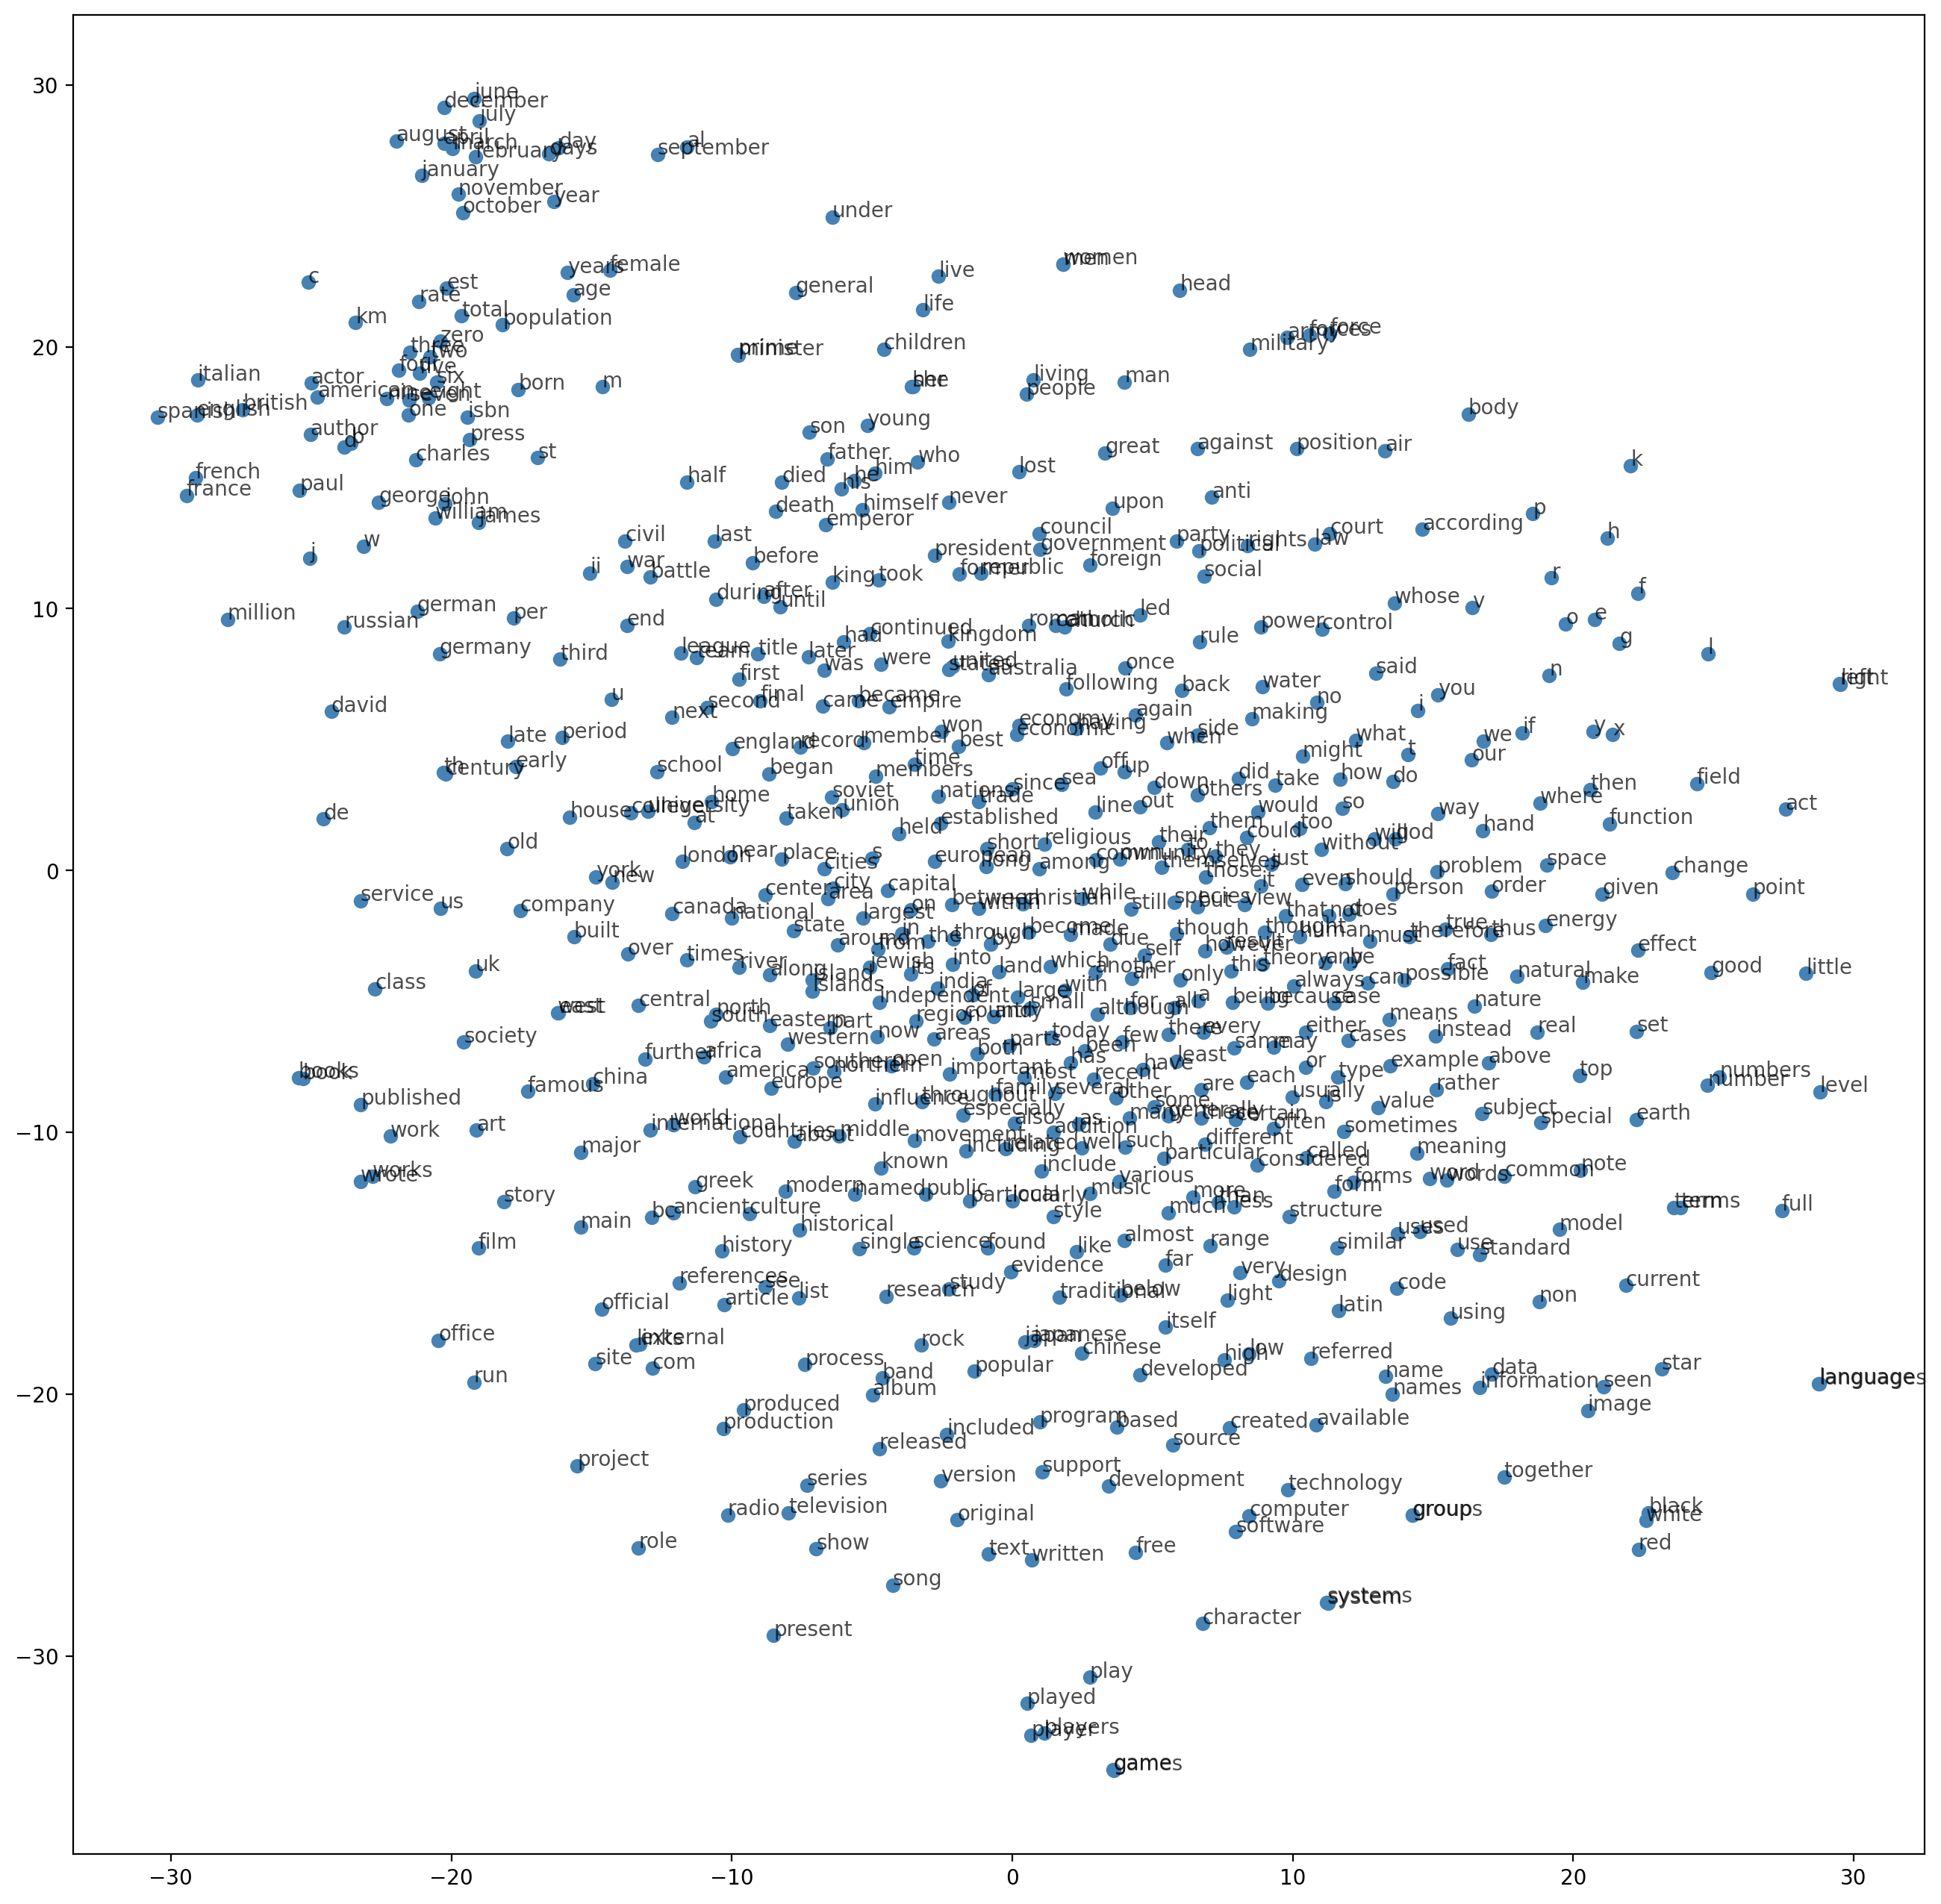

In [18]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color="steelblue")
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)